In [16]:
import pandas as pd
import numpy as np
import datetime
import sklearn
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa
import os
from pathlib import Path
import statsmodels
import scipy
import neurokit2 as nk

import tqdm 


from collections import Counter
import matplotlib.pyplot as plt

In [17]:
lstPIds = []
path = "./Data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)

[1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [18]:
lstAll = []
for pid in tqdm.tqdm(lstPIds):
    
    dfState = pd.read_csv(f"{path}ID{pid}-state.csv")

    dfStart = dfState[dfState.State == "start"].copy()
    dfEnd = dfState[dfState.State == "end"][["Time"]].iloc[:len(dfStart)]
    dfStart = dfStart.rename(columns={"Time":"TimeStart"})
    dfStart.TimeStart = dfStart.TimeStart #+ 60
    dfStart["TimeEnd"] = dfEnd.Time.values
    del dfStart["State"]
    dfStart["Duration"] = dfStart.TimeEnd - dfStart.TimeStart
    df = dfStart[dfStart.BlockNumber != -2].copy()

    dfNBack = pd.read_csv(f"{path}ID{pid}-feedback.csv")
    dfNBack = dfNBack[dfNBack.Time != "Time"]
    correct= (dfNBack["IsCorrect"]==True).count()

    lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart ) & (dfNBack.Time < e.TimeEnd )]
        if (len(dfX) == 0):
            print("No Data!")
        lstNBack.append(dfX.IsCorrect.mean())
    df["IsCorrect"] = lstNBack

    lstCorrectCount = []
    lstTotalTouchCount = []
    #lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time <= e.TimeEnd )]
        lstCorrectCount.append(len(dfX[dfX.IsCorrect == True]))
        lstTotalTouchCount.append(len(dfX))
    
    dfSphere = pd.read_csv(f"{path}ID{pid}-sphere.csv")
    del dfSphere["Feedback"]
    
    lstMissedCount = []
    for i, e in df.iterrows():
        dfX = dfSphere[(dfSphere.Time> e.TimeStart) & (dfSphere.Time <= e.TimeEnd )].reset_index(drop=True)
        missed = 0
        for i in range(0, len(dfX)-1):
            if ((dfX.iloc[i].Type == "up") & (dfX.iloc[i+1].Type == "down")):
                if(dfX.iloc[i+1].Time-dfX.iloc[i].Time > 4):
                    missed += 1
        lstMissedCount.append(missed)
    
    df["NBackCorrect"] = lstCorrectCount
    df["NBackMissed"] = lstMissedCount
    df["NBackTotal"] = np.array(lstTotalTouchCount) + np.array(lstMissedCount)
    df["NBackAccuracy"] = df["NBackCorrect"]/df["NBackTotal"] * 100
    
    df["NBackTimePerBall"] = df["Duration"] / np.array(lstTotalTouchCount)
    
    df.index = list(range(len(df)))
    df["PId"] = pid
    
    # Read Flow File
    dfFlow = pd.read_csv(f"{path}ID{pid}-flow.csv")
    dfFlow["TimeNorm"] = dfFlow.Time-dfState.Time.iloc[0]

    # Read Visitor File
    #dfLiams = pd.read_csv(f"{path}ID{pid}-visitor.csv")
    #dfLiams = dfLiams.drop_duplicates(subset=['Name'])
    #dfLiams["TimeNorm"] = dfLiams.Time-dfState.Time.iloc[0]

   ## Calculate Accuracy
    lstLiamData = []
    for i, e in df.iterrows():
        dfX = dfFlow[(dfFlow.Time > e.TimeStart) & (dfFlow.Time < e.TimeEnd )]
       
        if ((len(dfX) == 0)):
            print("No Data! Liams" + str(i))
           
        lstLiamData.append(len(dfX))
        
    #lstLiamClickData.append([total, truePositive, falsePositive, trueNegatives, falseNegatives])
    #lstLiamClickData = np.array(lstLiamClickData)
    df["LiamsCountTotal"] = lstLiamData
    #df["LiamsCounTruePositive"] = lstLiamClickData[:,1]
    #df["LiamsCountFalsePositive"] = lstLiamClickData[:,2]
    #df["LiamsCountTrueNegatives"] = lstLiamClickData[:,3]
    #df["LiamsCountFalseNegatives"] = lstLiamClickData[:,4]

   # df["Accuracy"] = (df.LiamsCounTruePositive +  df.LiamsCountTrueNegatives) / df.LiamsCountTotal
    df["Flow"] = df["LiamsCountTotal"] / df.Duration * 60
    # Read EDA
    dfEDA = pd.read_csv(f"{path}ID{pid}-EDA.csv")
    edaFs = 250  # Sampling frequency

    dfEDA.Value = (dfEDA.Value / 1000) / 25
    dfEDA["TimeNorm"] = dfEDA.Time-dfState.Time.iloc[0]
    dfEDA["EDAClean"] =  nk.eda_clean(dfEDA["Value"], sampling_rate=edaFs, method="neurokit") #scipy.signal.medfilt(dfEDA.Value, edaFs +1)
    #dfEDA.EDAClean.plot()
    #plt.show()
    #sos = scipy.signal.butter(1, 0.01, btype='lowpass', analog=False, output='sos', fs=edaFs)
    #dfEDA["EDAButter"] = scipy.signal.sosfilt(sos, dfEDA["EDAMedian"])
    signal, info=nk.eda_process(nk.standardize(dfEDA.EDAClean, sampling_rate=edaFs), sampling_rate=edaFs)
    #signal2, info = nk.eda_sympathetic(dfEDA.EDAClean, sampling_rate=edaFs, frequency_band=[0.045, 0.25], method='posada', show=False)
    signal, info =  nk.eda_process(dfEDA.EDAClean, sampling_rate=edaFs)
    dfEDA["EDARaw"] = signal.EDA_Raw
    dfEDA["EDATonic"] = signal.EDA_Tonic
    dfEDA["EDAPhasic"] = signal.EDA_Phasic
    #dfEDA["EDASCR"] = signal.SCR_Amplitude
    #dfEDA["EDASymp"] = signal2.EDA_Symp
    
    
    lstEDATonic = []
    lstEDATonicSD = []
    lstEDATonicMax = []
    lstEDATonicMin = []
    lstEDATonicDiff30 = []
    lstEDARaw = []
    #lstEDAMedian = []
    #lstEDAButter = []
    lstEDAPhasic = []
    #lstEDASCR = []
    #lstEDAFre = []
    
    #fig, axs = plt.subplots(1, 7, figsize=(10, 3))
    
    for i, e in df.iterrows():
        dfX = dfEDA[(dfEDA.Time > e.TimeStart) & (dfEDA.Time < e.TimeEnd )] # ALl data
        #dfX = dfEDA[(dfEDA.Time > e.TimeEnd - 30) & (dfEDA.Time < e.TimeEnd )] ## only last 30 sec
        #axs[i].plot(dfX.index, dfX.EDARaw.values)
        lstEDATonic.append(dfX.EDATonic.mean())
        lstEDARaw.append(dfX.EDARaw.mean())
        lstEDAPhasic.append(dfX.EDAPhasic.mean())
        lstEDATonicMax.append(dfX.EDATonic.max())
        lstEDATonicMin.append(dfX.EDATonic.min())
        lstEDATonicSD.append(dfX.EDATonic.std())
        #lstEDASCR.append(dfX.EDASCR.mean())
        #lstEDAFre.append(dfX.EDAFre.mean())
        #lstEDAMedian.append(dfX.EDAClean.mean())
        #lstEDAButter.append(dfX.EDAButter.mean())
        
        dfX = dfEDA[(dfEDA.Time > e.TimeStart) & (dfEDA.Time < e.TimeStart + 30)]
        dfY = dfEDA[(dfEDA.Time > e.TimeEnd - 30) & (dfEDA.Time < e.TimeEnd )]
        
        lstEDATonicDiff30.append(dfY.EDATonic.mean()-dfX.EDATonic.mean())

      # if i == 0:
      #     axis[i].text(dfX.index.min(), dfX.EDARaw.mean(), str(e.BlockNumber) + " - " + str(df.PId.unique()[0]))
      # else:
      #     axs[i].text(dfX.index.min(), dfX.EDARaw.mean(), e.BlockNumber)
            
    #plt.show()
    df["EDATonic"] = lstEDATonic
    df["EDARaw"] = lstEDARaw
    df["EDAPhasic"] = lstEDAPhasic
    df["EDATonicMin"] = lstEDATonicMin
    df["EDATonicMax"] = lstEDATonicMax
    df["EDATonicDiff30"] = lstEDATonicDiff30
    df["EDATonicSD"] = lstEDATonicSD
    #df["EDASCR"] = lstEDASCR
    #df["EDAClean"] = lstEDAClean
    #df["EDAButter"] = lstEDAButter
   # dfEDA["EDASymp"] = lstEDASymp
    
    
    
    # Read Flow File
    dfAdaptation = pd.read_csv(f"{path}ID{pid}-adaptation.csv")
    
    # Read Visitor File
    #dfLiams = pd.read_csv(f"{path}ID{pid}-visitor.csv")
    #dfLiams = dfLiams.drop_duplicates(subset=['Name'])
    #dfLiams["TimeNorm"] = dfLiams.Time-dfState.Time.iloc[0]

   ## Calculate Accuracy
    lstAdaptation = []
    for i, e in df.iterrows():
        dfX = dfAdaptation[(dfAdaptation.Time > e.TimeStart) & (dfAdaptation.Time < e.TimeEnd )]
       
        if ((len(dfX) == 0)):
            #print("No Data! Adaptaion" + str(i))
            lstAdaptation.append(None)
        else:
            x = (dfX.SlopeT2 - dfX.SlopeT1).mean()
            lstAdaptation.append(x)
        
    df["SlopeRatioMean"] = lstAdaptation
    
    lstAll.append(df)
    
dfAll = pd.concat(lstAll)
dfAll = dfAll.sort_values("TimeStart")
dfAll["Order"] = list(range(1,8)) *len(dfAll.PId.unique())

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [03:01<00:00, 10.69s/it]


In [19]:
dfAll.to_csv("adaptivedf.csv", index=False)
dfAll

,TimeStart,BlockNumber,AdaptationStatus,NBackN,TimeEnd,Duration,IsCorrect,NBackCorrect,NBackMissed,NBackTotal,...,Flow,EDATonic,EDARaw,EDAPhasic,EDATonicMin,EDATonicMax,EDATonicDiff30,EDATonicSD,SlopeRatioMean,Order
0,1.662020e+09,1,1,2,1.662020e+09,360.01669,0.915730,163,0,178,...,24.332205,6.075239,6.075241,0.000002,5.315152,6.894223,1.157636,0.395484,NaN,1
1,1.662020e+09,6,1,2,1.662021e+09,360.35229,0.941463,193,0,205,...,281.058294,7.970107,7.970232,0.000125,7.676365,8.395753,0.011290,0.165580,0.000089,2
2,1.662021e+09,4,1,2,1.662021e+09,360.05591,0.817734,166,0,203,...,272.790967,8.826208,8.826936,0.000728,8.330699,9.521457,0.187934,0.280551,NaN,3
3,1.662022e+09,2,1,2,1.662022e+09,360.02358,0.904977,200,0,221,...,110.659419,9.316826,9.318431,0.001604,8.890787,10.190812,-0.389246,0.320678,NaN,4
4,1.662022e+09,7,2,2,1.662023e+09,360.03858,0.730159,138,3,192,...,195.645700,9.707646,9.709179,0.001533,9.062581,10.812316,-1.003744,0.390328,-0.001916,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1.662648e+09,7,2,2,1.662648e+09,360.08251,0.877451,179,1,205,...,216.950276,9.732461,9.732633,0.000173,8.993073,10.503306,1.115288,0.408469,-0.001711,3
3,1.662649e+09,3,1,2,1.662649e+09,360.04636,0.847059,216,0,255,...,192.475213,10.356211,10.357670,0.001459,9.805696,11.034597,0.110809,0.277732,NaN,4
4,1.662649e+09,2,1,2,1.662649e+09,360.01682,0.901818,248,0,275,...,109.661543,10.263372,10.264708,0.001336,9.938499,11.164893,-0.246561,0.249604,NaN,5
5,1.662650e+09,5,1,2,1.662650e+09,360.06204,0.888889,232,1,262,...,342.940900,10.090248,10.089888,-0.000360,9.706020,10.907683,-0.518068,0.228388,NaN,6


In [20]:
for col in dfAll.columns:
    print(col)

TimeStart
BlockNumber
AdaptationStatus
NBackN
TimeEnd
Duration
IsCorrect
NBackCorrect
NBackMissed
NBackTotal
NBackAccuracy
NBackTimePerBall
PId
LiamsCountTotal
Flow
EDATonic
EDARaw
EDAPhasic
EDATonicMin
EDATonicMax
EDATonicDiff30
EDATonicSD
SlopeRatioMean
Order


In [28]:
dfAll.groupby("BlockNumber").Flow.describe()

,count,mean,std,min,25%,50%,75%,max
BlockNumber,,,,,,,,
1,17.0,24.332094,0.448948,23.664706,23.998615,24.332277,24.499025,25.165771
2,17.0,110.001393,1.217080,107.987117,109.490435,109.994754,110.659419,112.658299
3,17.0,191.182159,1.538697,188.486010,190.136836,191.311099,192.149240,193.965307
4,17.0,270.581217,2.770462,263.794585,270.454301,270.788134,272.303773,274.295968
5,17.0,346.706820,2.975572,340.442588,344.427441,346.592486,349.228070,351.094244
6,17.0,237.686925,31.126142,178.315918,216.812411,243.801774,258.486021,281.058294
7,17.0,216.056655,30.183766,146.323270,199.805144,216.950276,242.123555,260.640718


<AxesSubplot:xlabel='BlockNumber'>

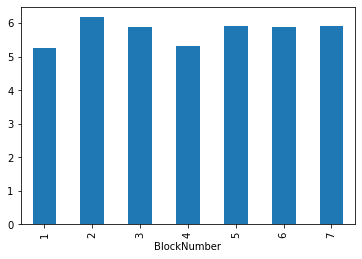

In [22]:
dfAll.groupby("BlockNumber").EDATonic.mean().plot(kind="bar")

In [23]:
dfAll.PId.unique()

array([ 1,  2,  3,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
      dtype=int64)

In [24]:
dfX = dfAll[["PId","TimeStart", "Order", "BlockNumber"]]
dfX

,PId,TimeStart,Order,BlockNumber
0,1,1.662020e+09,1,1
1,1,1.662020e+09,2,6
2,1,1.662021e+09,3,4
3,1,1.662022e+09,4,2
4,1,1.662022e+09,5,7
...,...,...,...,...
2,20,1.662648e+09,3,7
3,20,1.662649e+09,4,3
4,20,1.662649e+09,5,2
5,20,1.662650e+09,6,5


In [25]:
dfY = dfX.pivot(index='PId', columns='Order', values='BlockNumber')

## Effect Size calculator

In [26]:
df1 = dfAll[dfAll['BlockNumber']==6]
df2 = dfAll[dfAll['BlockNumber']==7]

In [27]:
from statistics import mean, stdev
from math import sqrt

cohens_d = (mean(df1['EDAPhasic']) - mean(df2['EDAPhasic'])) / (sqrt((stdev(df1['EDAPhasic']) ** 2 + stdev(df2['EDAPhasic']) ** 2) / 2))
print(cohens_d)


-0.7744677331168315
